<a href="https://colab.research.google.com/github/pidipidi/cs577_RLI/blob/master/PDDL_Planner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PDDL-based Task Planning

This notebook demonstrates the implementation of a task planner using PDDL (Planning Domain Definition Language) and its integration with [AI2-THOR simulation](https://ai2thor.allenai.org/).
In the AI2-THOR kitchen environment, we define and solve two distinct task‐planning problems with PDDL and execute the generated plans to achieve the specified goals.

---


## General Information




### Objectives

- Initialize the AI2-THOR simulation environment  
- Create PDDL **domain** and **problem** definitions  
- Find an optimal plan with **Pyperplan** (A* + FF heuristic)  
- Execute and verify the plan on AI2-THOR  

### Table of Contents

- Environment Setup  
- **Task 1: storeUtensils**  
   1. Task Context & Environment Setup  
   2. Define PDDL Domain & Problem defnitions
   3. Run Planner & Inspect Solution  
   4. Execute in AI2-THOR  
   5. Record Execution & Create Video  

- **Task 2: serveCoffee**  
   1. Task Context & Environment Setup  
   2. Define PDDL Domain & Problem defnitions  
   3. Run Planner & Inspect Solution  
   4. Execute in AI2-THOR  
   5. Record Execution & Create Video   

> **Note:** Run cells in order. Editable code cells allow you to tweak parameters or actions for hands-on experimentation.  


## 0. Environment Setup


### Set the type of the runtime 🚨

This tutorial uses an AI2THOR environment, which requires a **CPU** runtime in Colab.  
> Please go to **Runtime → Change runtime type** and select **CPU** before running any cells.

### Install necessary files for AI2-THOR

 To create the environment, upload the AI2THOR.zip file from the designated repository to your local machine. Run the code block below to upload the necessary files to your Colab.

*   AI2THOR.zip

In [1]:
from google.colab import files
uploaded = files.upload()

Saving AI2THOR_ws.zip to AI2THOR_ws.zip


In [41]:
import os

# 2. Change working directory to /content
%cd /content

# 3. Unzip the project archive from Drive
!unzip "/content/AI2THOR_ws.zip" > /dev/null
%cd AI2THOR_ws

# 4. Install required Python package
!pip install -r requirements.txt > /dev/null

/content
Archive:  /content/AI2THOR_ws.zip
replace AI2THOR_ws/task_planning/environments/serveCoffee.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace AI2THOR_ws/task_planning/environments/storeUtensils.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
/content/AI2THOR_ws


In [42]:
# Install or upgrade the AI2-THOR and Colab extension Python packages
!pip install --upgrade ai2thor ai2thor-colab &> /dev/null
import ai2thor
import ai2thor_colab

# Bring in the Controller class and visualization utilities
from ai2thor.controller import Controller
from ai2thor_colab import (
    plot_frames,
    show_objects_table,
    side_by_side,
    overlay,
    show_video
)

# Start the X-server for rendering in Colab
ai2thor_colab.start_xserver()
"AI2-THOR Version: " + ai2thor.__version__

'AI2-THOR Version: 5.0.0'

In [43]:
# Generate Controller Instance
controller = Controller()
%cd task_planning/

/content/AI2THOR_ws/task_planning


## 1. Task - storeUtensils

In this task, the agent must pick up a spoon and a fork from the countertop and place them in the drawer.

The PDDL planner generate a sequence of actions that are then executed and visualized in the AI2-THOR kitchen environment.




### 1.1. Task Context & Environment Setup

Initialize the robot and target objects in the scene.

In [45]:
# Define the task context for Task 1: storeUtensils
task_context = {
  "task_idx": 1,
  "task": "storeUtensils",
  "scene": "FloorPlan2",
  "robot_init_state": {
    "position": {
      "x": 1.0,
      "y": 0.9,
      "z": -0.75
    },
    "rotation": {
      "x": 0,
      "y": 180.0,
      "z": 0
    },
    "horizon": 50.0
  },
  "objects_init_state": [
    {
      "objectType": "Fork",
      "objectName": "Fork_40ceb846",
      "position": {
        "x": 1.0,
        "y": 0.93,
        "z": -1.41
      },
      "rotation": {
        "x": 0.0,
        "y": -0.0,
        "z": 0.0
      },
      "property": {}
    },
    {
      "objectType": "Spoon",
      "objectName": "Spoon_ab4315e1",
      "position": {
        "x": 0.89,
        "y": 0.93,
        "z": -1.41
      },
      "rotation": {
        "x": 0.0,
        "y": -0.0,
        "z": 0.0
      },
      "property": {}
    }
  ]
}


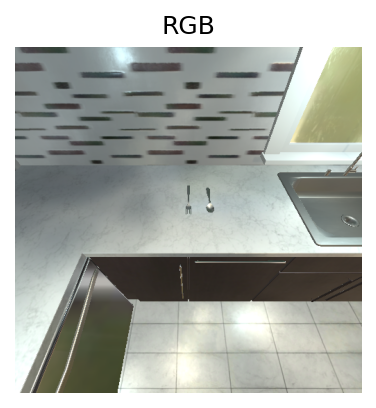

In [46]:
# Reset the AI2-THOR controller to load the specified scene
# and configure rendering parameters
controller.reset(
    scene = task_context["scene"],
    visibilityDistance=1.5,
    gridSize=0.05,
    fieldOfView=90,
    width=500,
    height=500,
    renderDepthImage=False,
    renderNormalsImage=False,
    renderInstanceSegmentation=False,
    renderSemanticSegmentation=False
)

# Prepare and send object poses to the controller
object_poses = []
for object_init_state in task_context["objects_init_state"]:
    object_poses.append(
        {
            "objectName": object_init_state["objectName"],
            "position": object_init_state["position"],
            "rotation": object_init_state["rotation"],
        }
    )
controller.step(action="SetObjectPoses", objectPoses=object_poses)
controller.step(action="Done")

# Teleport the agent to its initial position and orientation
controller.step(
    action="Teleport",
    position=task_context['robot_init_state']['position'],
    rotation=task_context['robot_init_state']['rotation'],
    horizon=task_context['robot_init_state']['horizon'],
    standing=True,
)

# Render and display the current camera view
plot_frames(controller.last_event)

### 1.2. Define PDDL Domain & Problem


### Construct the PDDL Domain

Create a **domain definition file** (`storeUtensils_domain.pddl`) that contains two sections—**Predicates** and **Action Schemas**—as described below.

---

### Predicates  
List every **predicate**—that is, each unary or binary relationship/attribute—that can appear in the initial state, goal conditions, or within an action’s preconditions and effects.

---

### Action Schemas  
Only **five** action names are permitted:

1. `open`  
2. `close`  
3. `pick-up`  
4. `place-on`  
5. `place-in`  

Every action must follow this exact template:

```
<action_name>           : Name of the action to define (e.g., ‘open’)
<parameters>            : ?variable
<conjunction-of-predicates> : All predicates that must hold before the action
<add-and-delete-list>       : Predicates to add (+) or remove (–) after execution

(:action <action_name>
  :parameters (<parameters>)
  :precondition (and
    <conjunction-of-predicates>
  )
  :effect (and
    <add-and-delete-list>
  )
)

```

In [9]:
# 1. Define the PDDL domain
store_utensils_domain = """; store-utensils_domain.pddl

(define (domain store-utensils)
  (:requirements :strips)

  (:predicates
    (at      ?o ?l)
    (in      ?o ?c)
    (holding ?o)
    (arm-empty)
    (open    ?c)
    (closed  ?c)
  )

  (:action open
    :parameters (?c)
    :precondition (closed ?c)
    :effect (and
      (open   ?c)
      (not (closed ?c))
    )
  )

  (:action close
    :parameters (?c)
    :precondition (open ?c)
    :effect (and
      (closed ?c)
      (not (open ?c))
    )
  )

  (:action pick-up
    :parameters (?o ?l)
    :precondition (and
      (at        ?o ?l)
      (arm-empty)
    )
    :effect (and
      (holding   ?o)
      (not (at   ?o ?l))
      (not (arm-empty))
    )
  )

  (:action place-on
    :parameters (?o ?l)
    :precondition (holding ?o)
    :effect (and
      (at        ?o ?l)
      (arm-empty)
      (not (holding ?o))
    )
  )

  (:action place-in
    :parameters (?o ?c)
    :precondition (and
      (holding ?o)
      (open    ?c)
    )
    :effect (and
      (in      ?o ?c)
      (arm-empty)
      (not (holding ?o))
    )
  )
)
"""

In [10]:
# 2. Save the PDDL domain into a file
with open("./pddl_files/storeUtensils_domain.pddl", "w") as f:
    f.write(store_utensils_domain)

print("✅ storeUtensils_domain.pddl saved successfully!")

✅ storeUtensils_domain.pddl saved successfully!


### Construct the PDDL Problem

Create a **single problem file** (`storeUtensils_problem.pddl`) that references the domain you just wrote and contains three key sections—**Objects**, **Initial State**, and **Goal Conditions**—as described below.

---

### Objects (`:objects`)
Declare every object (constant symbol) that participates in this specific planning instance.
> 📌 Note: Use exactly the following names (no variations or additional objects):
>
> `spoon` `fork` `drawer` `countertop`
---

### Initial State (`:init`)  
List all predicates that are **true** at the start of the episode.  
> 📌 Note:
> Even though the robotic arm is not visually rendered in the AI2-THOR scene, the planner should assume the agent starts in the arm-empty state.

---

### Goal Conditions (`:goal`)  
Specify the conditions that must hold when planning finishes.  
Wrap multiple predicates inside an `(and …)` expression.


In [11]:
# 1. Define the PDDL problem
store_utensils_problem = """; store-utensils_problem.pddl

(define (problem store-utensils-drawer)
  (:domain store-utensils)

  (:objects
    spoon fork table drawer
  )

  (:init
    (at        spoon table)
    (at        fork  table)
    (arm-empty)
    (closed    drawer)
  )

  (:goal
    (and
      (in spoon drawer)
      (in fork  drawer)
    )
  )
)
"""


In [12]:
# 2. Save the PDDL problem into a file
with open("./pddl_files/storeUtensils_problem.pddl", "w") as f:
    f.write(store_utensils_problem)

print("✅ storeUtensils_problem.pddl saved successfully!")

✅ storeUtensils_problem.pddl saved successfully!


## 3. Run Planner & Inspect Solution

We use **Pyperplan**, an open-source Python planner, to derive a plan from the PDDL files. It searches the state space with heuristic A* and saves the resulting action sequence to a .soln file for inspection and later execution.









In [13]:
# Generate a plan and save it to a .soln file
!pyperplan -l warning -s astar -H hff \
  ./pddl_files/storeUtensils_domain.pddl \
  ./pddl_files/storeUtensils_problem.pddl \
  > ./pddl_files/storeUtensils_problem.pddl.soln

# Print the plan so you can verify the exact action sequence
!cat ./pddl_files/storeUtensils_problem.pddl.soln

(open drawer)
(pick-up fork table)
(place-in fork drawer)
(pick-up spoon table)
(place-in spoon drawer)


## 4. Execute in AI2-THOR

In [14]:
import os
import json
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt

from ai2thor.controller import Controller
from ai2thor.platform import Linux64, CloudRendering
from actions import get_action_classes
from plan_success_checker import check_task_success


class Thor:
    """Thin wrapper around AI2-THOR’s Controller that:
       • sets up the scene from a task-context dictionary
       • executes high-level action classes (open, close, pick-up, …)
       • logs events / RGB frames for later analysis or video creation
    """

    def __init__(self, task_context: dict, scenario_idx: int, records_dir: str):
        """Create a Thor helper and immediately initialize the simulator."""
        self.controller = None
        self.counter = 0
        self.task_context = task_context
        self.records_dir = records_dir
        self.log_archive = {}

        # Available high-level actions (parsed from natural language commands).
        self.action_space = get_action_classes()
        self.init_env()

    # ----------------------------------------------------------------------
    # Environment setup
    # ----------------------------------------------------------------------
    def init_env(self):
        """Reset the AI2-THOR scene, place objects, and teleport the agent."""
        self.controller = Controller()
        # Scene-level parameters (FOV, resolution, etc.)
        self.controller.reset(
            scene=self.task_context["scene"],
            visibilityDistance=1.5,
            gridSize=0.05,
            fieldOfView=90,
            width=500,
            height=500,
            renderDepthImage=False,
            renderNormalsImage=False,
            renderInstanceSegmentation=False,
            renderSemanticSegmentation=False,
        )

        # Place all task-specific objects at their initial poses
        object_poses = [
            {
                "objectName": obj["objectName"],
                "position": obj["position"],
                "rotation": obj["rotation"],
            }
            for obj in self.task_context["objects_init_state"]
        ]
        self.controller.step(action="SetObjectPoses", objectPoses=object_poses)
        self.controller.step(action="Done")

        # Teleport the agent to its start pose (position, rotation, horizon)
        self.controller.step(
            action="Teleport",
            position=self.task_context["robot_init_state"]["position"],
            rotation=self.task_context["robot_init_state"]["rotation"],
            horizon=self.task_context["robot_init_state"]["horizon"],
            standing=True,
        )
        self.controller.step(action="Done")

    # ----------------------------------------------------------------------
    # Convenience properties
    # ----------------------------------------------------------------------
    @property
    def is_hand_empty(self) -> bool:
        """True if the agent is not holding any object."""
        return self.agent_state["isHolding"] is None

    @property
    def agent_state(self) -> dict:
        """Return the current agent metadata with an extra 'isHolding' field."""
        event = self.controller.last_event
        agent = event.metadata["agent"]
        agent["isHolding"] = None
        # Determine which object (if any) is currently picked up
        for obj in self.objects_state:
            if obj.get("pickupable") and obj.get("isPickedUp"):
                agent["isHolding"] = obj
                break
        return agent

    @property
    def objects_state(self) -> list:
        """Return metadata for all objects visible in the current frame."""
        return self.controller.last_event.metadata["objects"]

    @property
    def rgb_frame(self) -> np.ndarray:
        """Return the current RGB image rendered by AI2-THOR."""
        return self.controller.last_event.frame

    # ----------------------------------------------------------------------
    # Object-lookup helpers
    # ----------------------------------------------------------------------
    def get_objectsByType(self, objectType: str) -> list:
        """Return all objects of a given AI2-THOR objectType."""
        return [o for o in self.objects_state if o["objectType"].lower() == objectType.lower()]

    def get_objectById(self, objectId: str):
        """Return a single object by its unique objectId (or None)."""
        return next((o for o in self.objects_state if o["objectId"] == objectId), None)

    def get_objectByName(self, objectName: str):
        """Return a single object by its human-readable name (or None)."""
        return next((o for o in self.objects_state if o["name"] == objectName), None)

    def get_closestObject(self, objects: list):
        """Given a list of objects, return the one closest to the agent."""
        agent_pos = self.agent_state["position"]

        def euclidean(p):
            return ((p["x"] - agent_pos["x"]) ** 2 + (p["y"] - agent_pos["y"]) ** 2 + (p["z"] - agent_pos["z"]) ** 2) ** 0.5

        return min(objects, key=lambda o: euclidean(o["position"])) if objects else None

    # ----------------------------------------------------------------------
    # Logging utilities
    # ----------------------------------------------------------------------
    def log(self, success: bool, message: str):
        """Print and archive a log message for the current frame counter."""
        if not message:
            return
        tag = "[INFO]" if success else "[ERROR]"
        msg = f"Frame {self.counter:03d} | {tag} {message}"
        print(msg)
        self.log_archive[self.counter] = msg

    def save_data(self, log_flag: bool = True):
        """Save the current event + RGB frame and advance the frame counter."""
        if log_flag:
            os.makedirs(f"{self.records_dir}/events", exist_ok=True)
            with open(f"{self.records_dir}/events/step_{self.counter}.pickle", "wb") as f:
                pickle.dump(self.controller.last_event, f, protocol=pickle.HIGHEST_PROTOCOL)

        os.makedirs(f"{self.records_dir}/ego_img", exist_ok=True)
        plt.imsave(
            f"{self.records_dir}/ego_img/step_{self.counter}.png",
            np.asarray(self.rgb_frame, order="C"),
        )
        self.counter += 1

    # ----------------------------------------------------------------------
    # Plan-parsing helpers
    # ----------------------------------------------------------------------
    def parse_word(self, line: str) -> str | None:
        """Convert a single PDDL action line into a natural-language command."""
        parts = line.strip("()\n").split()
        mapping = {
            "pick-up": lambda p: f"pick up {p[1]}",
            "place-in": lambda p: f"place {p[1]} in {p[2]}",
            "place-on": lambda p: f"place {p[1]} on {p[2]}",
            "open": lambda p: f"open {p[1]}",
            "close": lambda p: f"close {p[1]}",
            "turn-on": lambda p: f"turn on {p[1]}",
            "turn-off": lambda p: f"turn off {p[1]}",
        }
        return mapping.get(parts[0], lambda p: None)(parts)

    def load_plan_from_soln(self, soln_path: str) -> list[str]:
        """Read a .soln file and return a list of natural-language commands."""
        commands = []
        with open(soln_path) as f:
            for line in f:
                cmd = self.parse_word(line)
                if cmd:
                    commands.append(cmd)
        return commands


In [15]:
# ---------------------------------------------------------------------------
# Main execution script
# ---------------------------------------------------------------------------
if __name__ == "__main__":

    # Initialize the AI2-THOR environment wrapper
    thor = Thor(task_context, scenario_idx=-1, records_dir="test/storeUtensils/")
    time.sleep(1)  # brief pause to ensure the simulator is ready

    # Read the planner output (.soln) and convert each line to a NL command
    soln_path = "pddl_files/storeUtensils_problem.pddl.soln"
    commands = thor.load_plan_from_soln(soln_path)

    # Parse natural-language commands into concrete action objects
    actions = []
    for cmd in commands:
        for action_cls in thor.action_space:
            args = action_cls.parse(cmd)
            if args is not None:
                actions.append(action_cls(thor, args))
                break

    # Execute each action sequentially in the simulator
    for idx, action in enumerate(actions, start=1):
        print(f"{idx}. Executing: {action}")
        action.execute()
        thor.log(success=True, message=f"after {action}")

1. Executing: <actions.open_action.Open object at 0x7d9f6e011390>
Frame 000 | [INFO] open drawer
Frame 001 | [INFO] open drawer succeeded
Frame 002 | [INFO] after <actions.open_action.Open object at 0x7d9f6e011390>
2. Executing: <actions.pickup_action.PickUp object at 0x7d9f6ab91e50>
Frame 002 | [INFO] pick up fork
Frame 003 | [INFO] pick up fork succeeded
Frame 004 | [INFO] after <actions.pickup_action.PickUp object at 0x7d9f6ab91e50>
3. Executing: <actions.placein_action.PlaceIn object at 0x7d9f6ab92450>
Frame 004 | [INFO] place fork in drawer
Frame 005 | [INFO] place fork in drawer succeeded
Frame 006 | [INFO] after <actions.placein_action.PlaceIn object at 0x7d9f6ab92450>
4. Executing: <actions.pickup_action.PickUp object at 0x7d9f6ab92210>
Frame 006 | [INFO] pick up spoon
Frame 007 | [INFO] pick up spoon succeeded
Frame 008 | [INFO] after <actions.pickup_action.PickUp object at 0x7d9f6ab92210>
5. Executing: <actions.placein_action.PlaceIn object at 0x7d9f6ab91ed0>
Frame 008 | [INF

In [16]:
import imageio, glob, os, numpy as np, PIL

# Convert saved PNG frames into an MP4 video
def make_video_from_frames(records_dir, output_fname="plan_execution.mp4", fps=4):
    img_dir = os.path.join(records_dir, "ego_img")
    pngs = sorted(glob.glob(f"{img_dir}/step_*.png"),
                  key=lambda p: int(os.path.splitext(os.path.basename(p))[0].split("_")[-1]))
    if not pngs:
        print("No frames to make video.")
        return
    out_path = os.path.join(records_dir, output_fname)
    with imageio.get_writer(out_path, fps=fps) as writer:
        for p in pngs:
            img = PIL.Image.open(p).convert("RGB")
            writer.append_data(np.array(img))
    print(f"Saved video: {out_path}")

# Build the video
if __name__ == "__main__":
    make_video_from_frames(
            records_dir=thor.records_dir,
            output_fname="storeUtensils.mp4",
            fps=4
        )

Saved video: test/storeUtensils/storeUtensils.mp4


In [17]:
# Play the execution video for the storeUtensils plan
from IPython.display import Video
Video("test/storeUtensils/storeUtensils.mp4", embed=True, width=400)

## Task 2: serveCoffee

In this task, the agent must take an empty mug from the countertop, fill it with coffee using the coffee machine, and then place the filled mug inside the refrigerator.

The PDDL planner will generate a sequence of actions that are then executed and visualized within the AI2-THOR kitchen environment.

### 1. Task Context & Environment Setup

In [18]:
# Define the task context for Task 2: serveCoffee
task_context = {
  "task_idx": 2,
  "task": "serveCoffee",
  "scene": "FloorPlan22",
  "robot_init_state": {
    "position": {
      "x": -2.0,
      "y": 0.9,
      "z": 0.4
    },
    "rotation": {
      "x": 0,
      "y": 270.0,
      "z": 0
    },
    "horizon": 40.0
  },
  "objects_init_state": [
    {
      "objectType": "CoffeeMachine",
      "objectName": "CoffeeMachine_7eed2c49",
      "position": {
        "x": -2.8,
        "y": 0.9,
        "z": 0.1
      },
      "rotation": {
        "x": -0.0,
        "y": 90.0,
        "z": 0.0
      },
      "property": {}
    },
    {
      "objectType": "Mug",
      "objectName": "Mug_7f8551ca",
      "position": {
        "x": -2.4,
        "y": 0.9,
        "z": 0.24
      },
      "rotation": {
        "x": 0.0,
        "y": 0.0,
        "z": 0.0
      },
      "property": {}
    }
  ]
}

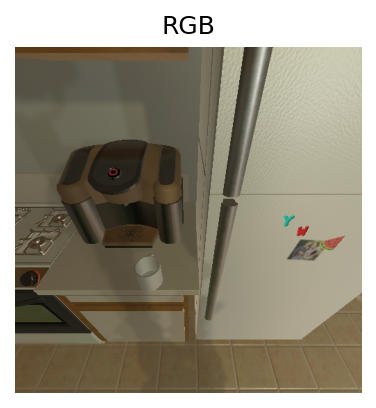

In [19]:
# Reset the AI2-THOR controller to load the specified scene
# and configure rendering parameters
controller.reset(
    scene = task_context["scene"],
    visibilityDistance=1.5,
    gridSize=0.05,
    fieldOfView=90,
    width=500,
    height=500,
    renderDepthImage=False,
    renderNormalsImage=False,
    renderInstanceSegmentation=False,
    renderSemanticSegmentation=False
)

# Prepare and send object poses to the controller
object_poses = []
for object_init_state in task_context["objects_init_state"]:
    object_poses.append(
        {
            "objectName": object_init_state["objectName"],
            "position": object_init_state["position"],
            "rotation": object_init_state["rotation"],
        }
    )
controller.step(action="SetObjectPoses", objectPoses=object_poses)
controller.step(action="Done")

# Teleport the agent to its initial position and orientation
controller.step(
    action="Teleport",
    position=task_context['robot_init_state']['position'],
    rotation=task_context['robot_init_state']['rotation'],
    horizon=task_context['robot_init_state']['horizon'],
    standing=True,
)

# Render and display the current camera view
plot_frames(controller.last_event)

## 2. Define PDDL Domain & Problem

### Construct the PDDL Domain

Create a **single domain file** (`serveCoffee_domain.pddl`) that contains two sections—**Predicates** and **Action Schemas**—as described below.

---

### Predicates  
List every **predicate**—that is, each unary or binary relationship/attribute—that can appear in the initial state, goal conditions, or within an action’s preconditions and effects.

---

### Action Schemas  
Only **five** action names are permitted:

1. `open`  
2. `close`  
3. `pick-up`  
4. `place-on`  
5. `place-in`
6. `turn-on`
> 📌 Note:  
> The `turn-on` action must take **two parameters**:
> - `?d` device to activate (e.g., `coffeemachine`)  
> - `?o` object that will be filled (e.g., `mug`)
7. `turn-off`

In [20]:
# 1. Define the PDDL domain
serve_coffee_domain = """; serve-coffee_domain.pddl

(define (domain serve-coffee)
  (:requirements :strips)

  (:predicates
    (at        ?o ?l)      ; object ?o is at location or device ?l
    (holding   ?o)         ; robot is holding object ?o
    (arm-empty)            ; robot arm is empty
    (off       ?d)         ; device ?d is off
    (on        ?d)         ; device ?d is on
    (filled    ?o)         ; object ?o is filled with coffee
    (open      ?c)         ; container ?c is open
    (closed    ?c)         ; container ?c is closed
    (surface   ?l)         ; place-on target
    (container ?c)         ; place-in target
  )

  (:action pick-up
    :parameters (?o ?l)
    :precondition (and (at ?o ?l) (arm-empty))
    :effect (and (holding ?o) (not (at ?o ?l)) (not (arm-empty)))
  )

  (:action place-on
    :parameters (?o ?l)
    :precondition (and (holding ?o) (surface ?l))
    :effect (and (at ?o ?l) (arm-empty) (not (holding ?o)))
  )

  (:action turn-on
    :parameters (?d ?o)
    :precondition (and (off ?d) (at ?o ?d))
    :effect (and (on ?d) (not (off ?d)) (filled ?o))
  )

  (:action turn-off
    :parameters (?d)
    :precondition (on ?d)
    :effect (and (off ?d) (not (on ?d)))
  )

  (:action open
    :parameters (?c)
    :precondition (and (closed ?c))
    :effect (and (open ?c) (not (closed ?c)))
  )

  (:action close
    :parameters (?c)
    :precondition (open ?c)
    :effect (and (closed ?c) (not (open ?c)))
  )

  (:action place-in
    :parameters (?o ?c)
    :precondition (and (holding ?o) (open ?c) (container ?c))
    :effect (and (at ?o ?c) (arm-empty) (not (holding ?o)))
  )
)
"""


In [21]:
# 2. Save the PDDL domain into a file
with open("./pddl_files/serveCoffee_domain.pddl", "w") as f:
    f.write(serve_coffee_domain)

print("✅ serveCoffee_domain.pddl saved successfully!")

✅ serveCoffee_domain.pddl saved successfully!


### Construct the PDDL Problem
Create a **single problem file** (`serveCoffee_problem.pddl`) that references the domain you just wrote and contains three key sections—**Objects**, **Initial State**, and **Goal Conditions**—as described below.

---

### Objects (`:objects`)
Declare every object (constant symbol) that participates in this specific planning instance.
> 📌 Note: Use exactly the following names (no variations or additional objects):
>
> `mug` `coffeemachine` `countertop` `fridge`  
---

### Initial State (`:init`)  
List all predicates that are **true** at the start of the episode.  
> 📌 Note:
> Even though the robotic arm is not visually rendered in the AI2-THOR scene, the planner should assume the agent starts in the arm-empty state.

---

### Goal Conditions (`:goal`)  
Specify the conditions that must hold when planning finishes.  
Wrap multiple predicates inside an `(and …)` expression.

In [22]:
# 1. Define the PDDL problem
serve_coffee_problem = """; serve-coffee_problem.pddl

(define (problem serve-coffee-fridge)
  (:domain serve-coffee)

  (:objects
    mug coffeemachine countertop fridge
  )

  (:init
    (at          mug          countertop)
    (off         coffeemachine)
    (closed      fridge)
    (arm-empty)
    (surface     countertop)
    (surface     coffeemachine)
    (container   fridge)
  )

  (:goal
    (and
      (filled mug)
      (at     mug fridge)
    )
  )
)
"""


In [23]:
# 2. Save the PDDL problem into a file
with open("./pddl_files/serveCoffee_problem.pddl", "w") as f:
    f.write(serve_coffee_problem)

print("✅ serveCoffee_problem.pddl saved successfully!")

✅ serveCoffee_problem.pddl saved successfully!


## 3. Run Planner & Inspect Solution

We use **Pyperplan**, an open-source Python planner, to derive a plan from the PDDL files. It searches the state space with heuristic A* and saves the resulting action sequence to a .soln file for inspection and later execution.

In [24]:
# Generate a plan and save it to a .soln file
!pyperplan -l warning -s astar -H hff   ./pddl_files/serveCoffee_domain.pddl   ./pddl_files/serveCoffee_problem.pddl   > ./pddl_files/serveCoffee_problem.pddl.soln

# Print the plan so you can verify the exact action sequence
!cat ./pddl_files/serveCoffee_problem.pddl.soln

(pick-up mug countertop)
(open fridge)
(place-on mug coffeemachine)
(turn-on coffeemachine mug)
(pick-up mug coffeemachine)
(place-in mug fridge)


In [25]:
# ---------------------------------------------------------------------------
# Main execution script
# ---------------------------------------------------------------------------
if __name__ == "__main__":

    # Initialize the AI2-THOR environment wrapper
    thor = Thor(task_context, scenario_idx=-1, records_dir="test/serveCoffee/")
    time.sleep(1)  # brief pause to ensure the simulator is ready

    # Read the planner output (.soln) and convert each line to a NL command
    soln_path = "pddl_files/serveCoffee_problem.pddl.soln"
    commands = thor.load_plan_from_soln(soln_path)

    # Parse natural-language commands into concrete action objects
    actions = []
    for cmd in commands:
        for action_cls in thor.action_space:
            args = action_cls.parse(cmd)
            if args is not None:
                actions.append(action_cls(thor, args))
                break

    # Execute each action sequentially in the simulator
    for idx, action in enumerate(actions, start=1):
        print(f"{idx}. Executing: {action}")
        action.execute()
        thor.log(success=True, message=f"after {action}")

1. Executing: <actions.pickup_action.PickUp object at 0x7d9f6ab923d0>
Frame 000 | [INFO] pick up mug
Frame 001 | [INFO] pick up mug succeeded
Frame 002 | [INFO] after <actions.pickup_action.PickUp object at 0x7d9f6ab923d0>
2. Executing: <actions.open_action.Open object at 0x7d9f6ab92190>
Frame 002 | [INFO] open fridge
Frame 003 | [INFO] open fridge succeeded
Frame 004 | [INFO] after <actions.open_action.Open object at 0x7d9f6ab92190>
3. Executing: <actions.placeon_action.PlaceOn object at 0x7d9f6df91090>
Frame 004 | [INFO] place mug on coffeemachine
Frame 005 | [INFO] place mug on coffeemachine succeeded
Frame 006 | [INFO] after <actions.placeon_action.PlaceOn object at 0x7d9f6df91090>
4. Executing: <actions.turnon.TurnOn object at 0x7d9f6df92510>
Frame 006 | [INFO] turn on coffeemachine
Frame 007 | [INFO] turn on coffeemachine succeeded
Frame 008 | [INFO] after <actions.turnon.TurnOn object at 0x7d9f6df92510>
5. Executing: <actions.pickup_action.PickUp object at 0x7d9f6df91310>
Frame 

In [26]:
import imageio, glob, os, numpy as np, PIL

# Convert saved PNG frames into an MP4 video
def make_video_from_frames(records_dir, output_fname="plan_execution.mp4", fps=4):
    img_dir = os.path.join(records_dir, "ego_img")
    pngs = sorted(glob.glob(f"{img_dir}/step_*.png"),
                  key=lambda p: int(os.path.splitext(os.path.basename(p))[0].split("_")[-1]))
    if not pngs:
        print("No frames to make video.")
        return
    out_path = os.path.join(records_dir, output_fname)
    with imageio.get_writer(out_path, fps=fps) as writer:
        for p in pngs:
            img = PIL.Image.open(p).convert("RGB")
            writer.append_data(np.array(img))
    print(f"Saved video: {out_path}")

# Build the video
if __name__ == "__main__":
    make_video_from_frames(
            records_dir=thor.records_dir,
            output_fname="serveCoffee.mp4",
            fps=4
        )

Saved video: test/serveCoffee/serveCoffee.mp4


In [27]:
# Play the execution video for the serveCoffee plan
from IPython.display import Video
Video("test/serveCoffee/serveCoffee.mp4", embed=True, width=400)

## Task 3: boilFood

In this task, the agent must place a tomato in a pot, fill the pot with water using the faucet, and then heat the tomato on the stoveburner. The tomato becomes hot only if all conditions are satisfied: the pot is on the stove, contains water, and the tomato is inside the pot.

The PDDL planner must reason over these conditional effects to generate a valid sequence of actions, which are then executed and visualized within the AI2-THOR kitchen environment.

### 1. Task Context & Environment Setup

In [28]:
task_context = {
  "task_idx": 3,
  "task": "boilFood",
  "scene": "FloorPlan1",
  "robot_init_state": {
    "position": {
      "x": -1.2,
      "y": 0.9,
      "z": -1.45
    },
    "rotation": {
      "x": 0,
      "y": 200.0,
      "z": 0
    },
    "horizon": 40.0
  },
  "objects_init_state": [
    {
      "objectType": "Pot",
      "objectName": "Pot_5c47f775",
      "position": {
        "x": -1.3,
        "y": 0.95,
        "z": -2.2
      },
      "rotation": {
        "x": -0.0,
        "y": 0.0,
        "z": 0.0
      },
      "property": {}
    },
    {
      "objectType": "Pan",
      "objectName": "Pan_21173d15",
      "position": {
        "x": -1.0,
        "y": 0.95,
        "z": -2.2
      },
      "rotation": {
        "x": 359.98,
        "y": 0.01,
        "z": 359.98
      },
      "property": {}
    },
    {
      "objectType": "Potato",
      "objectName": "Potato_4dee147d",
      "position": {
        "x": -1.66,
        "y": 0.93,
        "z": -2.15
      },
      "rotation": {
        "x": 0.06,
        "y": 0.0,
        "z": 0.08
      },
      "property": {}
    },
    {
      "objectType": "Tomato",
      "objectName": "Tomato_caaae6b0",
      "position": {
        "x": -1.66,
        "y": 0.93,
        "z": -2.3
      },
      "rotation": {
        "x": 0.0,
        "y": 0.0,
        "z": 0.0
      },
      "property": {}
    }
  ]
}

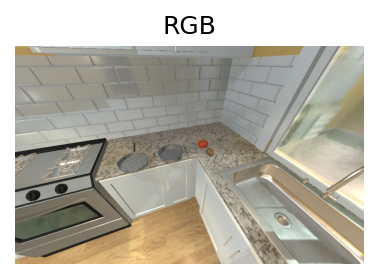

In [29]:
# Reset the AI2-THOR controller to load the specified scene
# and configure rendering parameters
controller.reset(
    scene = task_context["scene"],
    visibilityDistance=1.5,
    gridSize=0.05,
    fieldOfView=90,
    width=800,
    height=500,
    renderDepthImage=False,
    renderNormalsImage=False,
    renderInstanceSegmentation=False,
    renderSemanticSegmentation=False
)

# Prepare and send object poses to the controller
object_poses = []
for object_init_state in task_context["objects_init_state"]:
    object_poses.append(
        {
            "objectName": object_init_state["objectName"],
            "position": object_init_state["position"],
            "rotation": object_init_state["rotation"],
        }
    )
controller.step(action="SetObjectPoses", objectPoses=object_poses)
controller.step(action="Done")

# Teleport the agent to its initial position and orientation
controller.step(
    action="Teleport",
    position=task_context['robot_init_state']['position'],
    rotation=task_context['robot_init_state']['rotation'],
    horizon=task_context['robot_init_state']['horizon'],
    standing=True,
)

# Render and display the current camera view
plot_frames(controller.last_event)

## 2. Define PDDL Domain & Problem

### Construct the PDDL Domain

Create a **single domain file** (`boilFood_domain.pddl`) that contains two sections—**Predicates** and **Action Schemas**—as described below.

---

### Predicates  
List every **predicate**—that is, each unary or binary relationship/attribute—that can appear in the initial state, goal conditions, or within an action’s preconditions and effects.

---

### Action Schemas  
Only **five** action names are permitted:

1. `pick-up`  
2. `place-on`  
3. `place-in`
4. `turn-off`
5. `turn-on`
> 📌 Note:  
> **In this task, the turn-on action should behave differently depending on the device (e.g., faucet vs. stoveburner)**
>
> 🔹Use only one turn-on action
>
> 🔹Use `when` clauses to define conditional effects.

In [30]:
# 1. Define the PDDL domain
boil_food_domain = """; boil-food_domain.pddl

(define (domain boilFood)
  (:requirements :strips :conditional-effects :equality)

  ;; ───── Constants ─────
  ;; Fixed objects in the scene
  (:constants tomato pot sink faucet stoveburner countertop)

  ;; ───── Predicate Definitions ─────
  (:predicates
    (hand-empty)                  ;; The robotic hand is empty
    (holding ?o)                  ;; The robot is holding object ?o

    (on-top-of ?o ?s)             ;; Object ?o is on top of surface ?s
    (in ?o ?c)                    ;; Object ?o is inside container ?c

    (turned-on ?d)                ;; Device ?d is currently on
    (turned-off ?d)               ;; Device ?d is currently off

    (filled-with-water ?p)        ;; The pot ?p is filled with water
    (hot ?o)                      ;; Object ?o is hot (applies to pot and tomato)

    (faucet ?d)                   ;; Marks ?d as a faucet device
    (stoveburner ?d)              ;; Marks ?d as a stove burner
  )

  ;; ── 1. pick up <object> ──────────────-
  (:action pick-up
    :parameters (?o ?loc)         ;; loc = surface or container
    :precondition (and
      (hand-empty)
      (or (on-top-of ?o ?loc) (in ?o ?loc))
    )
    :effect (and
      (holding ?o)
      (not (hand-empty))
      (not (on-top-of ?o ?loc))
      (not (in ?o ?loc)))
  )

  ;; ── 2. place <object> in <container> ────────
  (:action place-in
    :parameters (?o ?c)
    :precondition (holding ?o)
    :effect (and
      (in ?o ?c)
      (hand-empty)
      (not (holding ?o)))
  )

  ;; ── 3. place <object> on <surface> ──────────
  (:action place-on
    :parameters (?o ?s)
    :precondition (holding ?o)
    :effect (and
      (on-top-of ?o ?s)
      (hand-empty)
      (not (holding ?o)))
  )

  ;; ── 4. turn on <device> ───────────────
  (:action turn-on
    :parameters (?d)
    :precondition (turned-off ?d)
    :effect (and
        (turned-on ?d) (not (turned-off ?d))

        ;; Faucet: fill pot with water if it is in the sink
        (when (and (faucet ?d) (in pot sink))
            (filled-with-water pot))

        ;; Stove: heat the pot if it is on the burner and filled
        (when (and (stoveburner ?d)
                (on-top-of pot stoveburner)
                (filled-with-water pot))
            (hot pot))

        ;; Stove: heat the tomato if pot is on burner, filled, and tomato is inside
        (when (and (stoveburner ?d)
                (on-top-of pot stoveburner)
                (filled-with-water pot)
                (in tomato pot))
            (hot tomato)))
  )

  ;; ── 5. turn off <device> ────────────────────
  (:action turn-off
    :parameters (?d)
    :precondition (turned-on ?d)
    :effect (and
      (turned-off ?d)
      (not (turned-on ?d)))
  )
)
"""


In [31]:
# 2. Save the PDDL domain into a file
with open("./pddl_files/boilFood_domain.pddl", "w") as f:
    f.write(boil_food_domain)

print("✅ boilFood_domain.pddl saved successfully!")

✅ boilFood_domain.pddl saved successfully!


### Construct the PDDL Problem
Create a **single problem file** (`boilFood_problem.pddl`) that references the domain you just wrote and contains three key sections—**Objects**, **Initial State**, and **Goal Conditions**—as described below.

---

### Objects (`:objects`)
Declare every object (constant symbol) that participates in this specific planning instance.
> 📌 Note: Use exactly the following names (no variations or additional objects):
>
> `tomato` `pot` `faucet` `stoveburner` `countertop`
---

### Initial State (`:init`)  
List all predicates that are **true** at the start of the episode.  
> 📌 Note:
> Even though the robotic arm is not visually rendered in the AI2-THOR scene, the planner should assume the agent starts in the arm-empty state.

---

### Goal Conditions (`:goal`)  
Specify the conditions that must hold when planning finishes.  
Wrap multiple predicates inside an `(and …)` expression.

In [32]:
# 1. Define the PDDL problem
boil_food_problem = """; boil-food_problem.pddl

(define (problem boilFood_problem)
  (:domain boilFood)

  (:init
    ;; The robot starts with an empty hand
    (hand-empty)

    ;; Tomato and pot are initially on the countertop
    (on-top-of tomato countertop)
    (on-top-of pot    countertop)

    ;; Both devices (faucet and stoveburner) are off initially
    (turned-off faucet)
    (turned-off stoveburner)

    ;; Declare device types (used for conditional effects)
    (faucet faucet)
    (stoveburner stoveburner)
  )

  (:goal
    (and
      ;; The tomato should be placed inside the pot
      (in tomato pot)

      ;; The pot must be hot (requires water + stove)
      (hot pot)

      ;; The tomato must also be hot (requires being in hot pot)
      (hot tomato)

      ;; The devices must be turned off
      (turned-off faucet)
      (turned-off stoveburner)
    )
  )
)
"""

In [33]:
# 2. Save the PDDL problem into a file
with open("./pddl_files/boilFood_problem.pddl", "w") as f:
    f.write(boil_food_problem)

print("✅ boilFood_problem.pddl saved successfully!")

✅ boilFood_problem.pddl saved successfully!


## 3. Run Planner & Inspect Solution

We use **Fast Downward**, a high-performance planning system written in C++, to derive a plan from the PDDL domain and problem files. It explores the state space using various heuristics and search strategies.

> ✅ Why We Use Fast Downward (instead of Pyperplan)
>
> Although Pyperplan is easy to set up and written in Python, it has limited support for PDDL features.
In particular, it does not support conditional effects, such as the when clause used in the `turn-on` action of the boilFood task.

In [34]:
# Install required build tools (compiler, cmake, Python headers)
!apt-get update -qq
!apt-get install -y build-essential cmake g++ python3-dev

# Clone the Fast Downward planning system (if not already cloned)
!git clone https://github.com/aibasel/downward.git || echo "repo exists"

# Build Fast Downward in release mode (optimized for speed)
!cd downward && ./build.py -j2 release

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
g++ is already the newest version (4:11.2.0-1ubuntu1).
g++ set to manually installed.
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
python3-dev is already the newest version (3.10.6-1~22.04.1).
python3-dev set to manually installed.
The following package was automatically installed and is no longer required:
  libxfont2
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 36 not upgraded.
Cloning into 'downward'...
remote: Enumerating objects: 88614, done.
remote: Counting objects: 100% (459/459), done.
remote: Compressing objects: 100% (398/398), done.
remote: Total 88614 (delta 167), reused 62 (del

In [35]:
%%bash
cd /content/AI2THOR_ws/AI2THOR_ws/task_planning

# Run Fast Downward planner using the default configuration (LAMA-2011 heuristic)
# No explicit output file is specified; plan will be saved to "sas_plan"
python3 downward/fast-downward.py \
    --alias seq-sat-lama-2011 \
    pddl_files/boilFood_domain.pddl \
    pddl_files/boilFood_problem.pddl

INFO     planner time limit: None
INFO     planner memory limit: None

INFO     Running translator.
INFO     translator stdin: None
INFO     translator time limit: None
INFO     translator memory limit: None
INFO     translator command line string: /usr/bin/python3 -m translate pddl_files/boilFood_domain.pddl pddl_files/boilFood_problem.pddl --sas-file output.sas
Parsing...
Parsing: [0.000s CPU, 0.003s wall-clock]
Normalizing task... [0.000s CPU, 0.000s wall-clock]
Instantiating...
Generating Datalog program... [0.000s CPU, 0.000s wall-clock]
Normalizing Datalog program...
Normalizing Datalog program: [0.010s CPU, 0.003s wall-clock]
Preparing model... [0.000s CPU, 0.001s wall-clock]
Generated 29 rules.
Computing model... [0.000s CPU, 0.001s wall-clock]
101 relevant atoms
67 auxiliary atoms
168 final queue length
221 total queue pushes
Completing instantiation... [0.000s CPU, 0.001s wall-clock]
Instantiating: [0.010s CPU, 0.006s wall-clock]
Computing fact groups...
Finding invariants...

bash: line 1: cd: /content/AI2THOR_ws/AI2THOR_ws/task_planning: No such file or directory


In [36]:
%%bash
cd /content/AI2THOR_ws/AI2THOR_ws/task_planning

# Get the most recently modified sas_plan* file (-t: sort by time, head -1: get latest)
PLAN_FILE=$(ls -t sas_plan* | head -n 1)

# Print and copy the latest plan file to a .soln file for inspection
echo "Copying $PLAN_FILE → pddl_files/boilFood_problem.pddl.soln"
cp "$PLAN_FILE" pddl_files/boilFood_problem.pddl.soln

# Print the final task plan (action sequence) saved in the .soln file
echo "----------- plan -----------"
cat pddl_files/boilFood_problem.pddl.soln

Copying sas_plan.1 → pddl_files/boilFood_problem.pddl.soln
----------- plan -----------
(pick-up pot countertop)
(place-in pot sink)
(turn-on faucet)
(turn-off faucet)
(pick-up tomato countertop)
(place-in tomato pot)
(pick-up pot sink)
(place-on pot stoveburner)
(turn-on stoveburner)
(turn-off stoveburner)
; cost = 10 (unit cost)


bash: line 1: cd: /content/AI2THOR_ws/AI2THOR_ws/task_planning: No such file or directory


In [37]:
cd /content/AI2THOR_ws/task_planning

[Errno 2] No such file or directory: '/content/AI2THOR_ws/AI2THOR_ws/task_planning'
/content/AI2THOR_ws/task_planning


In [38]:
import os
import json
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt

from ai2thor.controller import Controller
from ai2thor.platform import Linux64, CloudRendering
from actions import get_action_classes
from plan_success_checker import check_task_success


class Thor:
    """Thin wrapper around AI2-THOR’s Controller that:
       • sets up the scene from a task-context dictionary
       • executes high-level action classes (open, close, pick-up, …)
       • logs events / RGB frames for later analysis or video creation
    """

    def __init__(self, task_context: dict, scenario_idx: int, records_dir: str):
        """Create a Thor helper and immediately initialize the simulator."""
        self.controller = None
        self.counter = 0
        self.task_context = task_context
        self.records_dir = records_dir
        self.log_archive = {}

        # Available high-level actions (parsed from natural language commands).
        self.action_space = get_action_classes()
        self.init_env()

    # ----------------------------------------------------------------------
    # Environment setup
    # ----------------------------------------------------------------------
    def init_env(self):
        """Reset the AI2-THOR scene, place objects, and teleport the agent."""
        self.controller = Controller()
        # Scene-level parameters (FOV, resolution, etc.)
        self.controller.reset(
            scene=self.task_context["scene"],
            visibilityDistance=1.5,
            gridSize=0.05,
            fieldOfView=90,
            width=800,
            height=500,
            renderDepthImage=False,
            renderNormalsImage=False,
            renderInstanceSegmentation=False,
            renderSemanticSegmentation=False,
        )

        # Place all task-specific objects at their initial poses
        object_poses = [
            {
                "objectName": obj["objectName"],
                "position": obj["position"],
                "rotation": obj["rotation"],
            }
            for obj in self.task_context["objects_init_state"]
        ]
        self.controller.step(action="SetObjectPoses", objectPoses=object_poses)
        self.controller.step(action="Done")

        # Teleport the agent to its start pose (position, rotation, horizon)
        self.controller.step(
            action="Teleport",
            position=self.task_context["robot_init_state"]["position"],
            rotation=self.task_context["robot_init_state"]["rotation"],
            horizon=self.task_context["robot_init_state"]["horizon"],
            standing=True,
        )
        self.controller.step(action="Done")

    # ----------------------------------------------------------------------
    # Convenience properties
    # ----------------------------------------------------------------------
    @property
    def is_hand_empty(self) -> bool:
        """True if the agent is not holding any object."""
        return self.agent_state["isHolding"] is None

    @property
    def agent_state(self) -> dict:
        """Return the current agent metadata with an extra 'isHolding' field."""
        event = self.controller.last_event
        agent = event.metadata["agent"]
        agent["isHolding"] = None
        # Determine which object (if any) is currently picked up
        for obj in self.objects_state:
            if obj.get("pickupable") and obj.get("isPickedUp"):
                agent["isHolding"] = obj
                break
        return agent

    @property
    def objects_state(self) -> list:
        """Return metadata for all objects visible in the current frame."""
        return self.controller.last_event.metadata["objects"]

    @property
    def rgb_frame(self) -> np.ndarray:
        """Return the current RGB image rendered by AI2-THOR."""
        return self.controller.last_event.frame

    # ----------------------------------------------------------------------
    # Object-lookup helpers
    # ----------------------------------------------------------------------
    def get_objectsByType(self, objectType: str) -> list:
        """Return all objects of a given AI2-THOR objectType."""
        return [o for o in self.objects_state if o["objectType"].lower() == objectType.lower()]

    def get_objectById(self, objectId: str):
        """Return a single object by its unique objectId (or None)."""
        return next((o for o in self.objects_state if o["objectId"] == objectId), None)

    def get_objectByName(self, objectName: str):
        """Return a single object by its human-readable name (or None)."""
        return next((o for o in self.objects_state if o["name"] == objectName), None)

    def get_closestObject(self, objects: list):
        """Given a list of objects, return the one closest to the agent."""
        agent_pos = self.agent_state["position"]

        def euclidean(p):
            return ((p["x"] - agent_pos["x"]) ** 2 + (p["y"] - agent_pos["y"]) ** 2 + (p["z"] - agent_pos["z"]) ** 2) ** 0.5

        return min(objects, key=lambda o: euclidean(o["position"])) if objects else None

    # ----------------------------------------------------------------------
    # Logging utilities
    # ----------------------------------------------------------------------
    def log(self, success: bool, message: str):
        """Print and archive a log message for the current frame counter."""
        if not message:
            return
        tag = "[INFO]" if success else "[ERROR]"
        msg = f"Frame {self.counter:03d} | {tag} {message}"
        print(msg)
        self.log_archive[self.counter] = msg

    def save_data(self, log_flag: bool = True):
        """Save the current event + RGB frame and advance the frame counter."""
        if log_flag:
            os.makedirs(f"{self.records_dir}/events", exist_ok=True)
            with open(f"{self.records_dir}/events/step_{self.counter}.pickle", "wb") as f:
                pickle.dump(self.controller.last_event, f, protocol=pickle.HIGHEST_PROTOCOL)

        os.makedirs(f"{self.records_dir}/ego_img", exist_ok=True)
        plt.imsave(
            f"{self.records_dir}/ego_img/step_{self.counter}.png",
            np.asarray(self.rgb_frame, order="C"),
        )
        self.counter += 1

    # ----------------------------------------------------------------------
    # Plan-parsing helpers
    # ----------------------------------------------------------------------
    def parse_word(self, line: str) -> str | None:
        """Convert a single PDDL action line into a natural-language command."""
        parts = line.strip("()\n").split()
        mapping = {
            "pick-up": lambda p: f"pick up {p[1]}",
            "place-in": lambda p: f"place {p[1]} in {p[2]}",
            "place-on": lambda p: f"place {p[1]} on {p[2]}",
            "open": lambda p: f"open {p[1]}",
            "close": lambda p: f"close {p[1]}",
            "turn-on": lambda p: f"turn on {p[1]}",
            "turn-off": lambda p: f"turn off {p[1]}",
        }
        return mapping.get(parts[0], lambda p: None)(parts)

    def load_plan_from_soln(self, soln_path: str) -> list[str]:
        """Read a .soln file and return a list of natural-language commands."""
        commands = []
        with open(soln_path) as f:
            for line in f:
                cmd = self.parse_word(line)
                if cmd:
                    commands.append(cmd)
        return commands


In [39]:
# ---------------------------------------------------------------------------
# Main execution script
# ---------------------------------------------------------------------------
if __name__ == "__main__":

    # Initialize the AI2-THOR environment wrapper
    thor = Thor(task_context, scenario_idx=-1, records_dir="test/boilFood/")
    time.sleep(1)  # brief pause to ensure the simulator is ready

    # Read the planner output (.soln) and convert each line to a NL command
    soln_path = "pddl_files/boilFood_problem.pddl.soln"
    commands = thor.load_plan_from_soln(soln_path)

    # Parse natural-language commands into concrete action objects
    actions = []
    for cmd in commands:
        for action_cls in thor.action_space:
            args = action_cls.parse(cmd)
            if args is not None:
                actions.append(action_cls(thor, args))
                break

    # Execute each action sequentially in the simulator
    for idx, action in enumerate(actions, start=1):
        print(f"{idx}. Executing: {action}")
        action.execute()
        thor.log(success=True, message=f"after {action}")

1. Executing: <actions.pickup_action.PickUp object at 0x7d9f6df38310>
Frame 000 | [INFO] pick up pot
Frame 001 | [INFO] pick up pot succeeded
Frame 002 | [INFO] after <actions.pickup_action.PickUp object at 0x7d9f6df38310>
2. Executing: <actions.placein_action.PlaceIn object at 0x7d9f6ab92190>
Frame 002 | [INFO] place pot in sink
Frame 003 | [INFO] place pot in sink succeeded
Frame 004 | [INFO] after <actions.placein_action.PlaceIn object at 0x7d9f6ab92190>
3. Executing: <actions.turnon.TurnOn object at 0x7d9f6df914d0>
Frame 004 | [INFO] turn on faucet
Frame 005 | [INFO] turn on faucet succeeded
Frame 006 | [INFO] after <actions.turnon.TurnOn object at 0x7d9f6df914d0>
4. Executing: <actions.turnoff.TurnOff object at 0x7d9f6dd6e9d0>
Frame 006 | [INFO] turn off faucet
Frame 007 | [INFO] turn off faucet succeeded
Frame 008 | [INFO] after <actions.turnoff.TurnOff object at 0x7d9f6dd6e9d0>
5. Executing: <actions.pickup_action.PickUp object at 0x7d9f6df9d210>
Frame 008 | [INFO] pick up tomat

In [ ]:
import imageio, glob, os, numpy as np, PIL

# Convert saved PNG frames into an MP4 video
def make_video_from_frames(records_dir, output_fname="plan_execution.mp4", fps=4):
    img_dir = os.path.join(records_dir, "ego_img")
    pngs = sorted(glob.glob(f"{img_dir}/step_*.png"),
                  key=lambda p: int(os.path.splitext(os.path.basename(p))[0].split("_")[-1]))
    if not pngs:
        print("No frames to make video.")
        return
    out_path = os.path.join(records_dir, output_fname)
    with imageio.get_writer(out_path, fps=fps) as writer:
        for p in pngs:
            img = PIL.Image.open(p).convert("RGB")
            writer.append_data(np.array(img))
    print(f"Saved video: {out_path}")

# Build the video
if __name__ == "__main__":
    make_video_from_frames(
            records_dir=thor.records_dir,
            output_fname="boilFood.mp4",
            fps=4
        )

In [ ]:
# Play the execution video for the boilFood plan
from IPython.display import Video
Video("test/boilFood/boilFood.mp4", embed=True, width=800)